<a href="https://colab.research.google.com/github/YunanWu2168/PySpark_demo/blob/master/Pyspark_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Welcome to the PySpark World !**


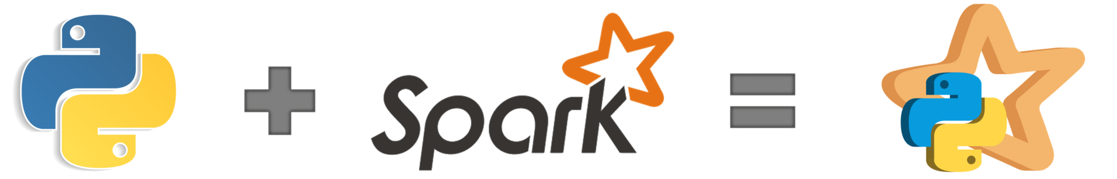
---





> ## **Why use Spark?**



*   Load the data to the disk
*   Import the data into the machine's memory
*   Process/analyze the data
*   Build the machine learning model
*   Store the prediction back to disk


> ## **How Does Spark work?**


*   Python
*   Java
*   Scala
*   SQL

<font color="blue"> Most importantly, Spark is like a biult-in library, including packages used in data analysis, machine learning. It is also designed to work with Hadoop clusters and can read types of files, such as CSV, JSON, and Hive data. </font>


> ## **Let's Begin !**


In this totorial, you will learn:


**1.   Install PySpark on Colab**

**2.   Basic operation with PySpark**


  *   Load the dataset (CPDB)
  *   Data preprocessing
  *   Statistics
  *   Basic Visualization
  
**3.   Play with the code**




> # **1. Install PySpark on Colab**

To run spark in Colab, we need to first install all the dependencies in Colab environment i.e. Apache Spark 2.4.7 (lastest one) with hadoop 2.7, Java 8 and Findspark to locate the spark in the system. The tools installation can be carried out inside the Jupyter Notebook of the Colab.
Follow the steps to install the dependencies:

The link to check the latest Spark version:
http://apache.mirror.amaze.com.au/spark/


In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz


# install findspark using pip
!pip install -q findspark

Now that you installed Spark and Java in Colab, it is time to set the environment path which enables you to run Pyspark in your Colab environment. Set the location of Java and Spark by running the following code:

In [ ]:
# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

Run a local spark session to test your installation:

In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

Then, import all the libraries we would use:

In [ ]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import SQLContext
import pandas as pd
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

> # **2. Load Dataset**

You can load the whole cpdb.sql but it is too large and wait for a long time.

I provided the link and code to downlaod the whole datasets




In [ ]:
# !gdown --id 1ahn0b2myXJ2eSoJu3z9BatW2T2QLGzvI       # the link for CPDB dataset

# with open("cpdb.sql") as fr:
#    query = fr.read()
# results = SQLContext.sql(query)

Downloading...
From: https://drive.google.com/uc?id=1ahn0b2myXJ2eSoJu3z9BatW2T2QLGzvI
To: /content/cpdb.sql
1.54GB [00:25, 61.3MB/s]


Therefore, we select one of the schemas in DataGrip and download it as the **cpdb_public_data_officer.csv**

First, to initiate a SparkContent

SparkContext is the internal engine that allows the connections with the clusters. If you want to run an operation, you need a SparkContext.

In [ ]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

Then, we download and read the .csv file.

In [ ]:
# download the file from Google Drive
!gdown --id 1_J0CttcRTVxWOsapHECfOMIq-PirL68F

# import the datasets
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",",")\
 .csv("cpdb_public_data_officer.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.")

There are 33839 rows 33 columns in the data.


In [ ]:
# show the dataframe
df.show(5)

+-----+------+-----+--------------+---------+-------+----------+----------+---------+----+--------------+-----------+----------------+--------------------+---------------+------------------------------+----------------------------+------------------------------+--------------+----------------+---------------+-------------------------+-------------+--------------+----------------+-----------------------+------------+-----------------+---------+-----------------+---------------+--------------------+--------------------+
|   id|gender| race|appointed_date|     rank| active|birth_year|first_name|last_name|tags|middle_initial|suffix_name|resignation_date|complaint_percentile|middle_initial2|civilian_allegation_percentile|honorable_mention_percentile|internal_allegation_percentile|trr_percentile|allegation_count|sustained_count|civilian_compliment_count|current_badge|current_salary|discipline_count|honorable_mention_count|last_unit_id|major_award_count|trr_count|unsustained_count|has_unique_

In [ ]:
# see data types of colums
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- race: string (nullable = true)
 |-- appointed_date: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- active: string (nullable = true)
 |-- birth_year: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- middle_initial: string (nullable = true)
 |-- suffix_name: string (nullable = true)
 |-- resignation_date: string (nullable = true)
 |-- complaint_percentile: double (nullable = true)
 |-- middle_initial2: string (nullable = true)
 |-- civilian_allegation_percentile: double (nullable = true)
 |-- honorable_mention_percentile: double (nullable = true)
 |-- internal_allegation_percentile: double (nullable = true)
 |-- trr_percentile: double (nullable = true)
 |-- allegation_count: integer (nullable = true)
 |-- sustained_count: integer (nullable = true)
 |-- civilian_compliment_count: integer (

 ># **3. Data Preprocessing and Statistics**

In [ ]:
# basic understanding of the data, i.e., mean, standard deviation, min and max
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' and t[0] != 'id']
df_sub = df.select(numeric_features)
df_sub.describe().toPandas().transpose()       

#toPandas - change spark DataFrame to pandas

,0,1,2,3,4
summary,count,mean,stddev,min,max
birth_year,32897,1956.50983372344,18.103345669129965,1915,1996
allegation_count,33839,7.381660214545347,10.953876319217938,0,175
sustained_count,33839,0.649841898401253,1.3900380229501774,0,28
civilian_compliment_count,33839,1.926534472058867,2.8720954212558696,0,69
current_badge,15364,11023.83135902109,6576.065097545669,1,60090
current_salary,19810,86467.81539626452,16967.48397171634,36984,260004
discipline_count,33839,0.5598569697686102,1.2636220312945967,0,28
honorable_mention_count,33839,12.061172020449776,23.39852996201198,0,337
last_unit_id,29918,60.92452704057758,74.23352673621002,2,258


In [ ]:
# target columns distribution
df.groupby('race').count().show()

+--------------------+-----+
|                race|count|
+--------------------+-----+
|       Asian/Pacific|  544|
|             Unknown|  185|
|               White|20722|
|Native American/A...|   67|
|            Hispanic| 4599|
|               Black| 7722|
+--------------------+-----+



In [ ]:
# check for null values
from pyspark.sql.functions import isnan, when, count, col
df_sub.select([count(when(isnan(c), c)).alias(c) for c in df_sub.columns]).toPandas().head()

,birth_year,allegation_count,sustained_count,civilian_compliment_count,current_badge,current_salary,discipline_count,honorable_mention_count,last_unit_id,major_award_count,trr_count,unsustained_count
0,0,0,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


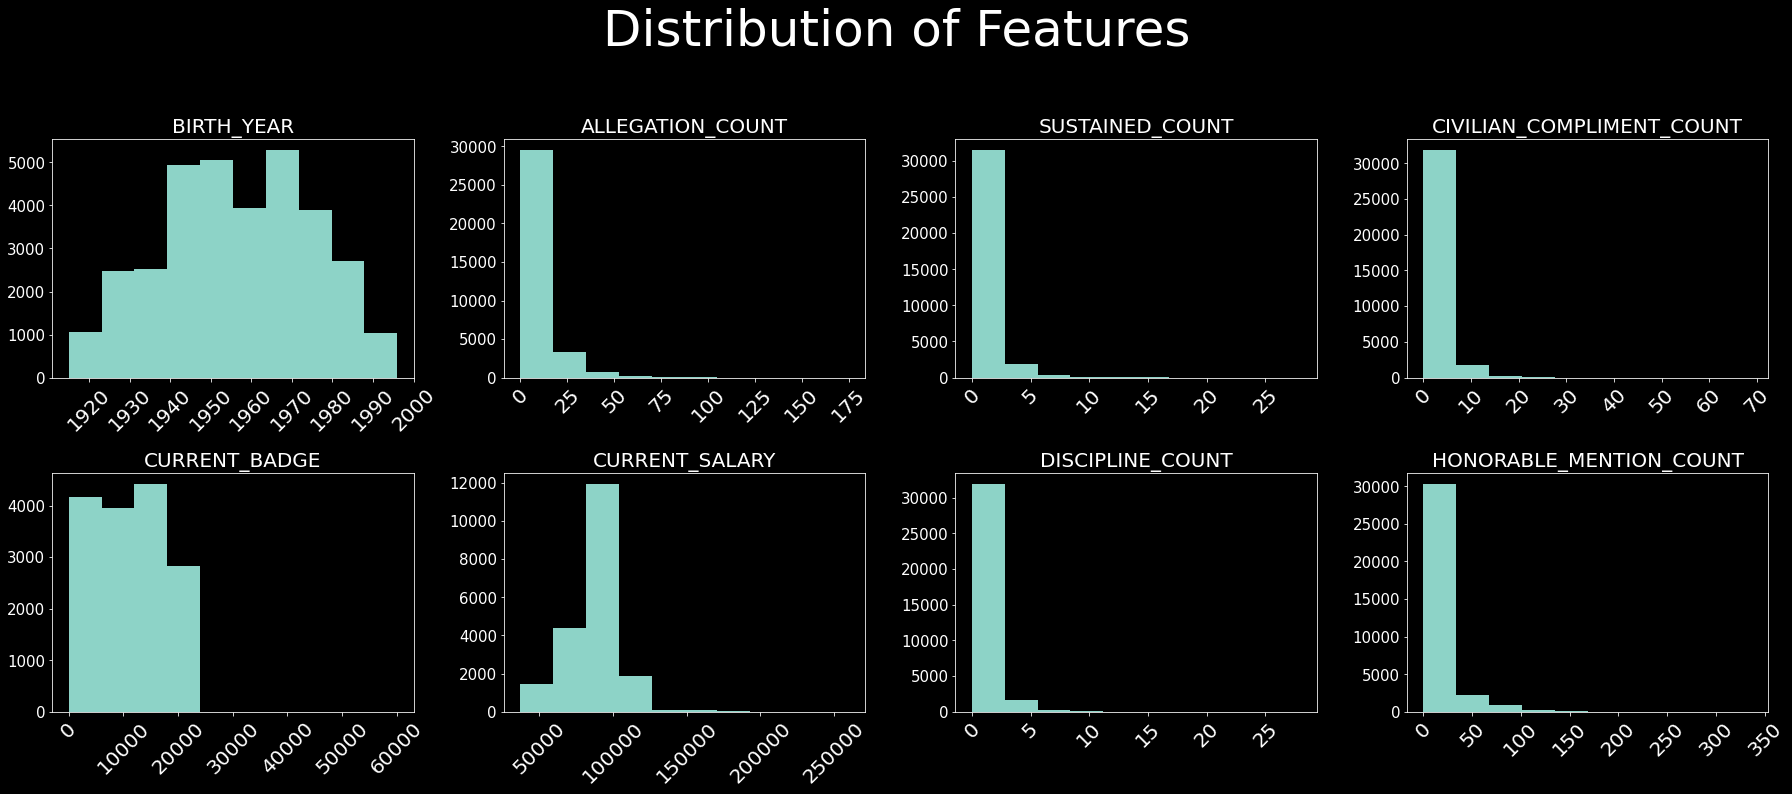

In [ ]:
# Distribution of Features
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df_sub.toPandas().describe().columns, range(1,9)):
    ax = fig.add_subplot(3,4,num)
    ax.hist(df.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

Create a new columns - define the function

There are three ways to create UDFs:

*   df = df.withColumn
*   df = sqlContext.sql(“sql statement from <df>”)
*   rdd.map(customFunction())


In [ ]:
# define whatever functions you want
# udf - user defined functions (really useful)
from pyspark.sql.functions import udf

def allegation_nultiple(all_count):
  if all_count == 0:
    return 'Good! No allegation'
  elif (all_count >= 0 and all_count < 10):
    return 'Slight 0<n<10'
  elif (all_count >= 10 and all_count < 30):
    return 'Moderate 10<n<30'
  else:
    return 'bad n>30'

defined_udf = udf(allegation_nultiple)
df = df.withColumn('allegation_level', defined_udf('allegation_count'))
df.show()

+-----+------+-------------+--------------+---------+-------+----------+----------+----------+----+--------------+-----------+----------------+--------------------+---------------+------------------------------+----------------------------+------------------------------+--------------+----------------+---------------+-------------------------+-------------+--------------+----------------+-----------------------+------------+-----------------+---------+-----------------+---------------+--------------------+--------------------+-------------------+
|   id|gender|         race|appointed_date|     rank| active|birth_year|first_name| last_name|tags|middle_initial|suffix_name|resignation_date|complaint_percentile|middle_initial2|civilian_allegation_percentile|honorable_mention_percentile|internal_allegation_percentile|trr_percentile|allegation_count|sustained_count|civilian_compliment_count|current_badge|current_salary|discipline_count|honorable_mention_count|last_unit_id|major_award_count|t

Another visualization - analyze and take two columns into consideration

+--------------------+---------+-----+------------------+
|                race|UserCount|total|           Percent|
+--------------------+---------+-----+------------------+
|               White|      849| 1581|53.700189753320686|
|               Black|      436| 1581|27.577482605945605|
|            Hispanic|      274| 1581| 17.33080328905756|
|       Asian/Pacific|       18| 1581|1.1385199240986716|
|Native American/A...|        4| 1581|0.2530044275774826|
+--------------------+---------+-----+------------------+



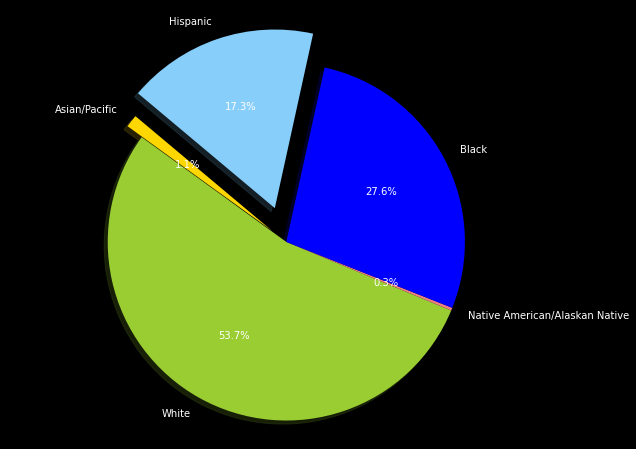

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window

# select rows with conditions
baddf = df.filter(df.allegation_level == "bad n>30") 
# baddf.show()

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)
tab = baddf.select(['allegation_level','race']).\
   groupBy('race').\
       agg(F.count('allegation_level').alias('UserCount')).\
       withColumn('total',sum(col('UserCount')).over(window)).\
       withColumn('Percent',col('UserCount')*100/col('total')).\
       sort(desc("Percent"))
tab.show()


# Data to plot
labels = list(tab.select('race').distinct().toPandas()['race'])
sizes =  list(tab.select('Percent').distinct().toPandas()['Percent'])
colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red']
explode = (0.1, 0.0, 0 ,0.0, 0.2)  # explode 1st slice

# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

Do pearson correlation

In [ ]:
from pyspark.mllib.stat import Statistics

df_sub.toPandas().head()
col_names = df_sub.columns

# correlations
features = df_sub.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,birth_year,allegation_count,sustained_count,civilian_compliment_count,current_badge,current_salary,discipline_count,honorable_mention_count,last_unit_id,major_award_count,trr_count,unsustained_count
birth_year,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
allegation_count,NaN,1.000000,0.493903,0.308298,NaN,NaN,0.486295,0.372496,NaN,0.163076,0.388821,0.925291
sustained_count,NaN,0.493903,1.000000,0.065988,NaN,NaN,0.964027,0.005565,NaN,0.023573,0.050267,0.415686
civilian_compliment_count,NaN,0.308298,0.065988,1.000000,NaN,NaN,0.067275,0.353688,NaN,0.137288,0.289963,0.233459
current_badge,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
current_salary,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
discipline_count,NaN,0.486295,0.964027,0.067275,NaN,NaN,1.000000,0.006034,NaN,0.025084,0.050485,0.412401
honorable_mention_count,NaN,0.372496,0.005565,0.353688,NaN,NaN,0.006034,1.000000,NaN,0.245067,0.674251,0.188591
last_unit_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
major_award_count,NaN,0.163076,0.023573,0.137288,NaN,NaN,0.025084,0.245067,NaN,1.000000,0.190075,0.117911


Other techniques that are useful in Machine Learning

1. LabelIndexer   (also like StringIndexer)

change Label to certain Group (for classification)

In [ ]:

label_indexer = StringIndexer()\
         .setInputCol ("gender")\
         .setOutputCol ("gender_label")

label_indexer_model=label_indexer.fit(df)
label_indexer_df=label_indexer_model.transform(df)
label_indexer_df.show(10)
# label_indexer_df.select("gender","gender_label").toPandas().head()

+-----+------+-------------+--------------+---------+-------+----------+----------+---------+----+--------------+-----------+----------------+--------------------+---------------+------------------------------+----------------------------+------------------------------+--------------+----------------+---------------+-------------------------+-------------+--------------+----------------+-----------------------+------------+-----------------+---------+-----------------+---------------+--------------------+--------------------+-------------------+------------+
|   id|gender|         race|appointed_date|     rank| active|birth_year|first_name|last_name|tags|middle_initial|suffix_name|resignation_date|complaint_percentile|middle_initial2|civilian_allegation_percentile|honorable_mention_percentile|internal_allegation_percentile|trr_percentile|allegation_count|sustained_count|civilian_compliment_count|current_badge|current_salary|discipline_count|honorable_mention_count|last_unit_id|major_aw

2.  VectorAssembler

Assemble features together

In [ ]:
# the code below runs if you change all the strings to digit numbers

# assembler = VectorAssembler()\
#          .setInputCols (["race","birth_year","civilian_allegation_percentile",
#                          "honorable_mention_percentile","allegation_count",\
#                          "sustained_count"])\
#          .setOutputCol ("vectorized_features")
        

# assembler_df=assembler.transform(df)
# assembler_df.show()

3.  StandardScaler

Normalize all the features before doing machine learning

In [ ]:
# scaler = StandardScaler()\
#          .setInputCol ("vectorized_features")\
#          .setOutputCol ("features")
        
# scaler_model=scaler.fit(label_indexer_df)
# scaler_df=scaler_model.transform(label_indexer_df)
# pd.set_option('display.max_colwidth', 40)
# scaler_df.select("vectorized_features","features").toPandas().head(5)

 ># **4. What to do next**

 It is good to do something advanced from here! I believe You can do everything now!
 
 A lot of useful tutorials and websites are online, please find the answers immediately when you are stuck.
